In [4]:
# 29/01/20- Based on Kooi_North Pacific_1D.py but using NEMO-MEDUSA profiles

from parcels import FieldSet, ParticleSet, JITParticle, ScipyParticle, AdvectionRK4_3D, AdvectionRK4, ErrorCode, ParticleFile, Variable, Field, NestedField, VectorField, timer #, polyTEOS10_bsq #seawaterdensity
from datetime import timedelta as delta
from datetime import  datetime
import numpy as np
import math
from glob import glob
import os
import xarray as xr
import sys
import time as timelib
import matplotlib.pyplot as plt
import warnings
import pickle
import matplotlib.ticker as mtick
import pandas as pd 
import operator
from numpy import *
import scipy.linalg
import math as math
warnings.filterwarnings("ignore")

minlat = 35
maxlat = 37
minlon = -161
maxlon = -159

#lon = np.array([-161,-159]) 
#lat = np.array([35,37]) 

simdays =  150
time0 = 0

#simhours = 1
#total_hours = 24*simdays
#dt = 60*60 # seconds in an hour (for the pickle profiles)
#total_secs = dt*24.*simdays - dt
#dt_secs = total_secs/dt

In [5]:
# """ Defining the particle class """

# class plastic_particle(JITParticle): # initals
#     u = Variable('u', dtype=np.float32,to_write=False)
#     v = Variable('v', dtype=np.float32,to_write=False)
#     #age = Variable('age', dtype=np.float32,to_write=True)
#     temp = Variable('temp',dtype=np.float32,to_write=True)
#     rho_sw = Variable('rho_sw',dtype=np.float32,to_write=False)
#     kin_visc = Variable('kin_visc',dtype=np.float32,to_write=False)
#     sw_visc = Variable('sw_visc',dtype=np.float32,to_write=False)
#     aa = Variable('aa',dtype=np.float32,to_write=True)
#     mu_aa = Variable('mu_aa',dtype=np.float32,to_write=False)
#     a = Variable('a',dtype=np.float32,to_write=True)
#     vs = Variable('vs',dtype=np.float32,to_write=True)
#     rho_tot = Variable('rho_tot',dtype=np.float32,to_write=True)
#     w = Variable('w',dtype=np.float32,to_write=True)

In [6]:
"""functions and kernals"""

def DeleteParticle(particle, fieldset, time):
    """Kernel for deleting particles if they are out of bounds."""
    print('particle is deleted') 
    #print(particle.lon, particle.lat, particle.depth)
    particle.delete()

def getclosest_ij(lats,lons,latpt,lonpt):     
    """Function to find the index of the closest point to a certain lon/lat value."""
    dist_sq = (lats-latpt)**2 + (lons-lonpt)**2                 # find squared distance of every point on grid
    minindex_flattened = dist_sq.argmin()                       # 1D index of minimum dist_sq element
    return np.unravel_index(minindex_flattened, lats.shape)     # Get 2D index for latvals and lonvals arrays from 1D index

def polyTEOS10_bsq(particle, fieldset, time):
    # calculates density based on the polyTEOS10-bsq algorithm from Appendix A.2 of
    # https://www.sciencedirect.com/science/article/pii/S1463500315000566
    # requires fieldset.abs_salinity and fieldset.cons_temperature Fields in the fieldset
    # and a particle.density Variable in the ParticleSet
    #
    # References:
    #  Roquet, F., Madec, G., McDougall, T. J., Barker, P. M., 2014: Accurate
    #   polynomial expressions for the density and specific volume of
    #   seawater using the TEOS-10 standard. Ocean Modelling.
    #  McDougall, T. J., D. R. Jackett, D. G. Wright and R. Feistel, 2003:
    #   Accurate and computationally efficient algorithms for potential
    #   temperature and density of seawater.  Journal of Atmospheric and
    #   Oceanic Technology, 20, 730-741.

    Z = - particle.depth  # note: use negative depths!
    SA = fieldset.abs_salinity[time, particle.depth, particle.lat, particle.lon]
    CT = fieldset.cons_temperature[time, particle.depth, particle.lat, particle.lon]

    SAu = 40 * 35.16504 / 35
    CTu = 40
    Zu = 1e4
    deltaS = 32
    R000 = 8.0189615746e+02
    R100 = 8.6672408165e+02
    R200 = -1.7864682637e+03
    R300 = 2.0375295546e+03
    R400 = -1.2849161071e+03
    R500 = 4.3227585684e+02
    R600 = -6.0579916612e+01
    R010 = 2.6010145068e+01
    R110 = -6.5281885265e+01
    R210 = 8.1770425108e+01
    R310 = -5.6888046321e+01
    R410 = 1.7681814114e+01
    R510 = -1.9193502195e+00
    R020 = -3.7074170417e+01
    R120 = 6.1548258127e+01
    R220 = -6.0362551501e+01
    R320 = 2.9130021253e+01
    R420 = -5.4723692739e+00
    R030 = 2.1661789529e+01
    R130 = -3.3449108469e+01
    R230 = 1.9717078466e+01
    R330 = -3.1742946532e+00
    R040 = -8.3627885467e+00
    R140 = 1.1311538584e+01
    R240 = -5.3563304045e+00
    R050 = 5.4048723791e-01
    R150 = 4.8169980163e-01
    R060 = -1.9083568888e-01
    R001 = 1.9681925209e+01
    R101 = -4.2549998214e+01
    R201 = 5.0774768218e+01
    R301 = -3.0938076334e+01
    R401 = 6.6051753097e+00
    R011 = -1.3336301113e+01
    R111 = -4.4870114575e+00
    R211 = 5.0042598061e+00
    R311 = -6.5399043664e-01
    R021 = 6.7080479603e+00
    R121 = 3.5063081279e+00
    R221 = -1.8795372996e+00
    R031 = -2.4649669534e+00
    R131 = -5.5077101279e-01
    R041 = 5.5927935970e-01
    R002 = 2.0660924175e+00
    R102 = -4.9527603989e+00
    R202 = 2.5019633244e+00
    R012 = 2.0564311499e+00
    R112 = -2.1311365518e-01
    R022 = -1.2419983026e+00
    R003 = -2.3342758797e-02
    R103 = -1.8507636718e-02
    R013 = 3.7969820455e-01
    ss = math.sqrt((SA + deltaS) / SAu)
    tt = CT / CTu
    zz = -Z / Zu
    rz3 = R013 * tt + R103 * ss + R003
    rz2 = (R022 * tt + R112 * ss + R012) * tt + (R202 * ss + R102) * ss + R002
    rz1 = (((R041 * tt + R131 * ss + R031) * tt + (R221 * ss + R121) * ss + R021) * tt + ((R311 * ss + R211) * ss + R111) * ss + R011) * tt + (((R401 * ss + R301) * ss + R201) * ss + R101) * ss + R001
    rz0 = (((((R060 * tt + R150 * ss + R050) * tt + (R240 * ss + R140) * ss + R040) * tt + ((R330 * ss + R230) * ss + R130) * ss + R030) * tt + (((R420 * ss + R320) * ss + R220) * ss + R120) * ss + R020) 
           * tt + ((((R510 * ss + R410) * ss + R310) * ss + R210) * ss + R110) * ss + R010) * tt + (((((R600 * ss + R500) * ss + R400) * ss + R300) * ss + R200) * ss + R100) * ss + R000
    particle.density = ((rz3 * zz + rz2) * zz + rz1) * zz + rz0

def Profiles(particle, fieldset, time):  
    particle.temp = fieldset.T[time, particle.depth,particle.lat,particle.lon]  
    particle.rho_sw = fieldset.D[time,particle.depth,particle.lat,particle.lon] 
    particle.kin_visc = fieldset.KV[time,particle.depth,particle.lat,particle.lon] 
    particle.sw_visc = fieldset.SV[time,particle.depth,particle.lat,particle.lon] 
    particle.aa = fieldset.AA[time,particle.depth,particle.lat,particle.lon]
    particle.mu_aa = fieldset.AAmu[time,particle.depth,particle.lat,particle.lon]

def Kooi(particle,fieldset,time):  
    z = particle.depth           # [m]
    t = particle.temp            # [oC]
    sw_visc = particle.sw_visc   # [kg m-1 s-1]
    aa = particle.aa             # [no m-3]
    mu_aa = particle.mu_aa/86400.       # [s-1] : check, is it growth rate?
    kin_visc = particle.kin_visc # [m2 s-1]
    rho_sw = particle.rho_sw     # [kg m-3]
    a = particle.a # [no. m-2 s-1]
    vs = particle.vs #10/(24*60*60) #particle.depth #particle.vs

    #print(vs)
    #------ CHOOSE -----
    rho_pl = 920.                 # density of plastic (kg m-3): DEFAULT FOR FIG 1: 920 but full range is: 840, 920, 940, 1050, 1380 (last 2 are initially non-buoyant)
    r_pl = 10.**(-4)               # radius of plastic (m): DEFAULT FOR FIG 1: 10-3 to 10-6 included but full range is: 10 mm to 0.1 um or 10-2 to 10-7

    #------ Constants and algal properties -----
    g = 7.32e10/(86400.**2.)    # gravitational acceleration (m d-2), now [s-2]
    k = 1.0306E-13/(86400.**2.) # Boltzmann constant [m2 kg d-2 K-1] now [s-2] (=1.3804E-23)
    rho_bf = 1388.            # density of biofilm ([g m-3]
    v_a = 2.0E-16             # Volume of 1 algal cell [m-3]
    m_a = 0.39/86400.          # mortality rate, now [s-1]
    r20 = 0.1/86400.           # respiration rate, now [s-1] 
    q10 = 2.                  # temperature coefficient respiration [-]
    gamma = 1.728E5/86400.     # shear [d-1], now [s-1]
    
    #------ Volumes -----
    v_pl = (4./3.)*math.pi*r_pl**3.           # volume of plastic [m3]
    theta_pl = 4.*math.pi*r_pl**2.            # surface area of plastic particle [m2]
    r_a = ((3./4.)*(v_a/math.pi))**(1./3.)      # radius of algae [m]
    
    v_bf = (v_a*a)*theta_pl                      # volume of biofilm [m3]
    v_tot = v_bf + v_pl                           # volume of total [m3]
    t_bf = ((v_tot*(3./(4.*math.pi)))**(1./3.))-r_pl  # biofilm thickness [m] 
    
    
    r_tot = r_pl + t_bf                           # total radius [m]
    particle.rho_tot = (r_pl**3. * rho_pl + ((r_pl + t_bf)**3. - r_pl**3.)*rho_bf)/(r_pl + t_bf)**3. # total density [kg m-3]
    rho_tot = particle.rho_tot
    theta_tot = 4.*math.pi*r_tot**2.                # surface area of total [m2]
    d_pl = k * (t + 273.16)/(6. * math.pi * sw_visc * r_tot)  # diffusivity of plastic particle [m2 s-1]
    d_a = k * (t + 273.16)/(6. * math.pi * sw_visc * r_a)     # diffusivity of algal cells [m2 s-1] 
    beta_abrown = 4.*math.pi*(d_pl + d_a)*(r_tot + r_a)       # Brownian motion [m3 s-1] 
    beta_ashear = 1.3*gamma*((r_tot + r_a)**3.)               # advective shear [m3 s-1]
    beta_aset = (1./2.)*math.pi*r_tot**2. * abs(vs)                  # differential settling [m3 s-1]
    beta_a = beta_abrown + beta_ashear + beta_aset           # collision rate [m3 s-1]
    
    a_coll = (beta_a*aa)/theta_pl
    a_growth = mu_aa*a
    a_mort = m_a*a
    a_resp = (q10**((t-20.)/10.))*r20*a     
    
    particle.a += (a_coll + a_growth - a_mort - a_resp) * particle.dt

    dn = 2. * (r_tot) # equivalent spherical diameter [m]
    delta_rho = (rho_tot - rho_sw)/rho_sw         # normalised difference in density between total plastic+bf and seawater[-]        
    d = ((rho_tot - rho_sw) * g * dn**3.)/(rho_sw * kin_visc**2.) # [-]
    
    if dn > 5e9:
        w = 1000.
    elif dn <0.05:
        w = (d**2.) *1.71E-4
    else:
        w = 10.**(-3.76715 + (1.92944*math.log10(d)) - (0.09815*math.log10(d)**2.) - (0.00575*math.log10(d)**3.) + (0.00056*math.log10(d)**4.))
    
    if z >= 4000.: 
        vs = 0
    elif z < 1. and delta_rho < 0:
        vs = 0  
    elif delta_rho > 0:
        vs = (g * kin_visc * w * delta_rho)**(1./3.)
    else: 
        a_del_rho = delta_rho*-1.
        vs = -1.*(g * kin_visc * w * a_del_rho)**(1./3.)  # m s-1

    particle.depth += vs * particle.dt #particle.vs
    particle.vs = vs
    z = particle.depth
    dt = particle.dt

In [7]:
# dirread = '/projects/0/topios/hydrodynamic_data/NEMO-MEDUSA/ORCA0083-N006/means/'
# ufiles = (dirread+'ORCA0083-N06_20070105d05T.nc')
# u_test = xr.open_dataset(ufiles)

# dirread_bgc = '/projects/0/topios/hydrodynamic_data/NEMO-MEDUSA_BGC/ORCA0083-N006/means/'  
# ppfiles = (dirread_bgc+'ORCA0083-N06_20070105d05D.nc')
# p_test = xr.open_dataset(ppfiles)

In [8]:
# FOR NOW: only 1 day (05 01 2007), and time_extrapolation = True

""" Defining the fieldset""" 

dirread = '/projects/0/topios/hydrodynamic_data/NEMO-MEDUSA/ORCA0083-N006/means/'
dirread_bgc = '/projects/0/topios/hydrodynamic_data/NEMO-MEDUSA_BGC/ORCA0083-N006/means/'  
dirread_mesh = '/projects/0/topios/hydrodynamic_data/NEMO-MEDUSA/ORCA0083-N006/domain/'  


#def get_nemo_fieldset():
ufiles = (dirread+'ORCA0083-N06_20070105d05U.nc')
vfiles = (dirread+'ORCA0083-N06_20070105d05V.nc')
wfiles = (dirread+'ORCA0083-N06_20070105d05W.nc')
ppfiles = (dirread_bgc+'ORCA0083-N06_20070105d05D.nc')
pfiles = (dirread_bgc+'ORCA0083-N06_20070105d05P.nc')
tsfiles = (dirread+'ORCA0083-N06_20070105d05T.nc')
mesh_mask = dirread_mesh+'coordinates.nc'

filenames = {'U': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': wfiles, 'data': ufiles},
             'V': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': wfiles, 'data': vfiles},
             'W': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': wfiles, 'data': wfiles},
             'mu_A': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': wfiles, 'data': ppfiles},
             'cons_temperature': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': wfiles, 'data': tsfiles},
             'abs_salinity': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': wfiles, 'data': tsfiles}}


variables = {'U': 'uo',
             'V': 'vo',
             'W': 'wo',
             'mu_A': 'TPP3',
             'cons_temperature': 'potemp',
             'abs_salinity': 'salin'}

dimensions = {'U': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw', 'time': 'time_centered'},
              'V': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw', 'time': 'time_centered'},
              'W': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw', 'time': 'time_centered'},
              'mu_A': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw','time': 'time_centered'},
              'cons_temperature': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw','time': 'time_centered'},
              'abs_salinity': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw','time': 'time_centered'}}



initialgrid_mask = dirread+'ORCA0083-N06_20070105d05U.nc'
mask = xr.open_dataset(initialgrid_mask, decode_times=False)
Lat, Lon = mask.variables['nav_lat'], mask.variables['nav_lon']
latvals = Lat[:]; lonvals = Lon[:] # extract lat/lon values to numpy arrays

iy_min, ix_min = getclosest_ij(latvals, lonvals, minlat, minlon)
iy_max, ix_max = getclosest_ij(latvals, lonvals, maxlat, maxlon)

indices = {'lon': range(ix_min, ix_max), 'lat': range(iy_min, iy_max)}  # 'depth': range(0, 2000)

fieldset = FieldSet.from_nemo(filenames, variables, dimensions, allow_time_extrapolation=True,indices=indices)
lons = fieldset.U.lon
lats = fieldset.U.lat
fieldMesh_x,fieldMesh_y = np.meshgrid(lons,lats)

         It will be opened with no decoding. Filling values might be wrongly parsed.


[[35.055916 35.055916 35.055916 ... 35.055916 35.055916 35.055916]
 [35.055252 35.055252 35.055252 ... 35.055252 35.055252 35.055252]
 [35.054592 35.054592 35.054592 ... 35.054592 35.054592 35.054592]
 ...
 [36.968807 36.968807 36.968807 ... 36.968807 36.968807 36.968807]
 [36.96783  36.96783  36.96783  ... 36.96783  36.96783  36.96783 ]
 [36.966854 36.966854 36.966854 ... 36.966854 36.966854 36.966854]]


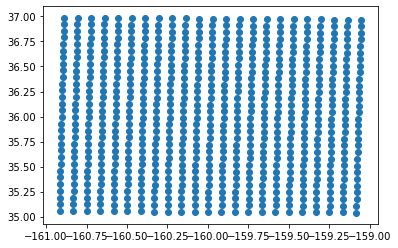

In [15]:
print(fieldMesh_y[:,0:11])
plt.scatter(lons,lats)
# pp_test = xr.open_dataset(ppfiles)
# pp2 = pp_test.variables['TPP3']
# plt.scatter(lonvals[iy_min:iy_max,ix_min:ix_max],latvals[iy_min:iy_max,ix_min:ix_max],pp2[0,0,iy_min:iy_max,ix_min:ix_max],c=pp2[0,0,iy_min:iy_max,ix_min:ix_max])